# Project - Orbits



In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
#from imblearn import under_sampling, over_sampling


## Loading the dataset

In [2]:
# Read in the dataset
pd.set_option('display.max_columns', 50)
df = pd.read_csv('shortenedorbit.csv', low_memory=False)
#df = df.drop(columns=df.columns[0], axis=1)
df = df.drop(['Name', 'Arc_years', 'Number','Computer', 'Last_obs', 'Principal_desig',
              'Other_desigs','Ref', 'Hex_flags', 'U'],axis='columns')

df['Perturbers'] = df['Perturbers'].fillna('No_Coarse')
df['Perturbers_2'] = df['Perturbers_2'].fillna('No_Precise')
df = df.drop(df[df['Orbit_type'] == 'MBA'].sample(frac=.50).index)
possibleLabels = df.Orbit_type.value_counts()

labeldummies = pd.get_dummies(df.Orbit_type)
pert1dummies = pd.get_dummies(df.Perturbers)
pert2dummies = pd.get_dummies(df.Perturbers_2)
df = pd.concat([pert1dummies,pert2dummies,df],axis='columns')
#df = df.drop(['Orbit_type'],axis='columns')
df = df.drop(['Perturbers'],axis='columns')
df = df.drop(['Perturbers_2'],axis='columns')
df = df.fillna(0)
df.head()

,M-h,M-v,No_Coarse,38h,3Eh,3Ek,No_Precise,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Epoch,M,Peri,Node,i,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
0,0,1,0,1,0,0,0,0.0,0.0,0.0,16.80,0.15,121.0,0.22,2459200.5,347.29934,292.08908,115.44159,3.69920,0.123595,0.184896,3.051533,6,2.459269e+06,5.330613,2.674377,3.428689,1.502459,1.230914,MBA
2,0,1,0,1,0,0,0,0.0,0.0,0.0,16.80,0.15,171.0,0.32,2459200.5,14.03074,202.06597,152.13493,14.20004,0.221219,0.215091,2.758806,10,2.459135e+06,4.582282,2.148507,3.369106,1.311898,1.279152,MBA
5,0,1,0,0,0,1,0,0.0,0.0,0.0,17.79,0.15,211.0,0.55,2459200.5,303.21970,180.59257,189.65732,5.43086,0.182016,0.284133,2.291511,10,2.459400e+06,3.468830,1.874419,2.708603,1.107797,1.405050,MBA
7,0,1,0,0,0,1,0,0.0,0.0,0.0,14.19,0.15,1161.0,0.54,2459200.5,231.94039,139.18996,285.60788,0.78627,0.132331,0.176895,3.142861,18,2.459924e+06,5.571701,2.726962,3.558760,1.543912,1.218737,MBA
8,0,1,0,1,0,0,0,0.0,0.0,0.0,18.90,0.15,71.0,0.28,2459000.5,34.97530,101.77973,297.90119,2.51215,0.185273,0.298116,2.219281,4,2.458883e+06,3.306120,1.808109,2.630454,1.071551,1.433629,MBA


All possible orbit classifications

In [3]:
possibleLabels

MBA                                           1127
Hungaria                                        54
Object with perihelion distance < 1.665 AU      53
Apollo                                          34
Jupiter Trojan                                  26
Amor                                            24
Phocaea                                         19
Hilda                                           19
Aten                                            10
Distant Object                                   8
Name: Orbit_type, dtype: int64

All features of our dataset (excl. orbit type)

In [4]:
df.dtypes
df.columns

Index(['M-h', 'M-v', 'No_Coarse', '38h', '3Eh', '3Ek', 'No_Precise',
       'NEO_flag', 'One_km_NEO_flag', 'PHA_flag', 'H', 'G', 'Num_obs', 'rms',
       'Epoch', 'M', 'Peri', 'Node', 'i', 'e', 'n', 'a', 'Num_opps', 'Tp',
       'Orbital_period', 'Perihelion_dist', 'Aphelion_dist',
       'Semilatus_rectum', 'Synodic_period', 'Orbit_type'],
      dtype='object')

## Preprocessing

Splitting the data, scaling the data, and label encoding

In [4]:
le = preprocessing.LabelEncoder()
y_cm = np.unique(df['Orbit_type'])
y = df['Orbit_type']
y = le.fit_transform(y)

np.unique(y)
df = df.drop(['Orbit_type'], axis = 'columns')



In [5]:
X = df.iloc[:,:40]
X_scaled = preprocessing.scale(X)



X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, random_state=42)

smt = SMOTE(k_neighbors=3)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
print("Shapes of data")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_train_smt:", X_train_smt.shape)
print("y_train_smt:", y_train_smt.shape)
print("y_test:",Counter(y_test))
print("y_train",Counter(y_train_smt))

Shapes of data
X_train: (1030, 29)
y_train: (1030,)
X_test: (344, 29)
y_test: (344,)
X_train_smt: (8500, 29)
y_train_smt: (8500,)
y_test: Counter({7: 277, 5: 17, 8: 11, 6: 10, 4: 9, 9: 6, 1: 4, 2: 4, 0: 4, 3: 2})
y_train Counter({7: 850, 1: 850, 8: 850, 3: 850, 6: 850, 9: 850, 5: 850, 4: 850, 2: 850, 0: 850})


## LOGISTICS

In [17]:
#using lbfgs solver 
logreg= LogisticRegression(max_iter=5000, C= 10, penalty= "l2",  solver='saga')

logreg.fit(X_train, y_train)
log_reg_y_pred_test=logreg.predict(X_test)
log_reg_y_pred_training=logreg.predict(X_train_smt)
print("Accuracy of test:",metrics.accuracy_score(y_test, log_reg_y_pred_test))
print("Accuracy of training:",metrics.accuracy_score(y_train_smt, log_reg_y_pred_training))
#print("Precision:",metrics.precision_score(y_test, y_pred))
#print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy of test: 0.9680232558139535
Accuracy of training: 0.9054117647058824


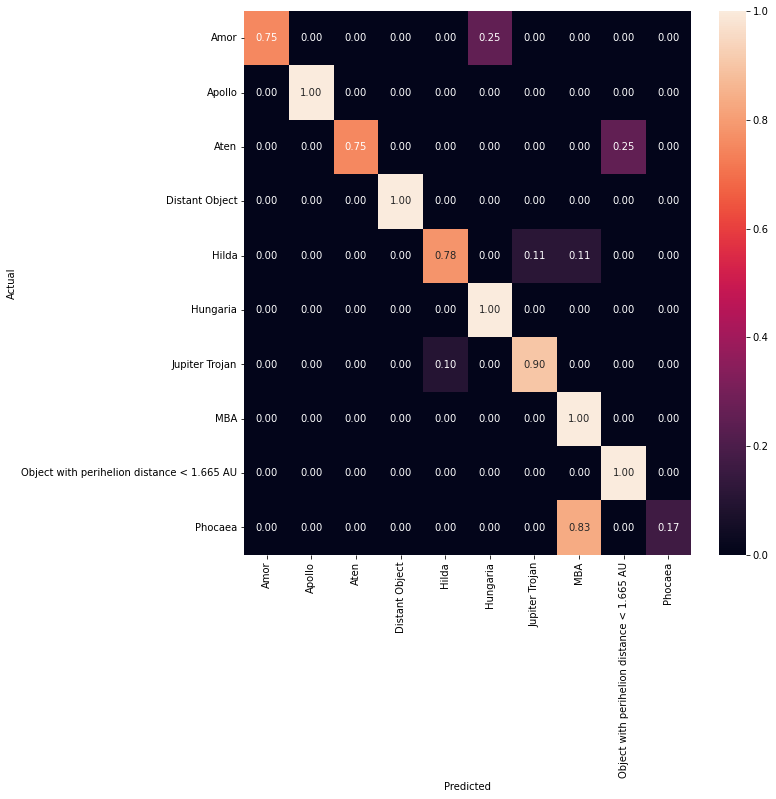

In [20]:



cm = confusion_matrix(y_test, log_reg_y_pred_test)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Logistic Regression Test Confusion Matrix.png')
plt.show(block=False)


In [9]:
#Testing L2/L1 Norm
LogRegWithNorm = LogisticRegression(max_iter=50000, C= 1, penalty= "l1", solver='saga')
LogRegWithNorm.fit(X_train,y_train)
y_pred2 = LogRegWithNorm.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.9534883720930233


In [10]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
kf = KFold(n_splits=10)
LogReg_training_acc = []
LogReg_test_acc = []

LogRegL1_training_acc = []
LogRegL1_test_acc = []

LogRegL2_training_acc = []
LogRegL2_test_acc = []

In [11]:
def logReg_SagaSolver_training(cval, penaltyL1L2):
    logRegSaga = LogisticRegression(max_iter=50000, C= cval, penalty= penaltyL1L2, solver='saga')
    logRegSaga.fit(X_train, y_train)
    
    logReg_y_prediction = logRegSaga.predict(X_test)
    return metrics.accuracy_score(logReg_y_prediction, y_test)
    

In [13]:
def logisticRegression_cost(cval):
    logRegNoPenalty = LogisticRegression(max_iter=1000, C= cval, penalty= "none",  solver='saga')
    logRegL1 = LogisticRegression(max_iter=1000, C= cval, penalty= "l1", solver='saga')
    logRegL2 = LogisticRegression(max_iter=1000, C= cval, penalty= "l2", solver='saga')
    
    train_logReg = []
    train_logRegL1 = []
    train_logRegL2 = []

    test_logReg = []
    test_logRegL1 = []
    test_logRegL2 = [] 
    
    for train, test in kf.split(X_train):
        X_tr = X_train[train,:]
        y_tr = y_train[train]
        X_ts = X_train[test,:]
        y_ts = y_train[test]
        
        X_tr = preprocessing.scale(X_tr)
        X_ts = preprocessing.scale(X_ts)
        
        sm = SMOTE(k_neighbors=3)
        X_tr_smt, y_tr_smt = sm.fit_resample(X_tr, y_tr)
        
        logRegNoPenalty.fit(X_tr_smt,y_tr_smt)
        logRegNopenalty_yhat_train = logRegNoPenalty.predict(X_tr_smt)
        logRegNoPenalty_yhat_test = logRegNoPenalty.predict(X_ts)
        train_logReg.append(metrics.accuracy_score(y_tr_smt, logRegNopenalty_yhat_train))
        test_logReg.append(metrics.accuracy_score(y_ts, logRegNoPenalty_yhat_test))
        
        
        
        logRegL1.fit(X_tr_smt,y_tr_smt)
        logRegL1_yhat_train = logRegL1.predict(X_tr_smt)
        logRegL1_yhat_test = logRegL1.predict(X_ts)
        train_logRegL1.append(metrics.accuracy_score(y_tr_smt, logRegL1_yhat_train))
        test_logRegL1.append(metrics.accuracy_score(y_ts, logRegL1_yhat_test))
        
        
        logRegL2.fit(X_tr_smt,y_tr_smt)
        logRegL2_yhat_train = logRegL2.predict(X_tr_smt)
        logRegL2_yhat_test = logRegL2.predict(X_ts)
        train_logRegL2.append(metrics.accuracy_score(y_tr_smt, logRegL2_yhat_train))
        test_logRegL2.append(metrics.accuracy_score(y_ts, logRegL2_yhat_test))
        
    
    print("hi")
    LogReg_training_acc.append(np.mean(train_logReg))
    LogReg_test_acc.append(np.mean(test_logReg))
    
    LogRegL1_training_acc.append(np.mean(train_logRegL1))
    LogRegL1_test_acc.append(np.mean(test_logRegL1))

    LogRegL2_training_acc.append(np.mean(train_logRegL2))
    LogRegL2_test_acc.append(np.mean(test_logRegL2))

        



In [14]:
for c in cvals:
    print(c)
    logisticRegression_cost(c)

0.0001


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\ana

hi
0.001


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\ana

hi
0.01


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\ana

hi
0.1


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: 

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarn

hi
1


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\pr

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


hi
10


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarn

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarn

hi
100


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\li

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\li

hi


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [15]:
for idx, x in enumerate(cvals):
    print("current c value:", x)
    
    print("training values in regular logreg: ",LogReg_training_acc[idx])
    print("test values in regular logreg: ",LogReg_test_acc[idx])
    #print("\n")

    print("training values in L1 logreg: ",LogRegL1_training_acc[idx])
    print("test values in L1 logreg: ",LogRegL1_test_acc[idx])
    #print("\n")

    print("training values in L2 logreg: ",LogRegL2_training_acc[idx])
    print("test values in L2 logreg: ",LogRegL2_test_acc[idx])
    print("\n")

current c value: 0.0001
training values in regular logreg:  0.9957213601275801
test values in regular logreg:  0.7126213592233009
training values in L1 logreg:  0.12000000000000002
test values in L1 logreg:  0.10776699029126213
training values in L2 logreg:  0.7600319637015165
test values in L2 logreg:  0.33592233009708733


current c value: 0.001
training values in regular logreg:  0.9955225435968658
test values in regular logreg:  0.7145631067961166
training values in L1 logreg:  0.5163020595570484
test values in L1 logreg:  0.23980582524271843
training values in L2 logreg:  0.8912422530206194
test values in L2 logreg:  0.587378640776699


current c value: 0.01
training values in regular logreg:  0.9957877880440771
test values in regular logreg:  0.7155339805825243
training values in L1 logreg:  0.9420291382820567
test values in L1 logreg:  0.729126213592233
training values in L2 logreg:  0.9596501304733349
test values in L2 logreg:  0.7106796116504854


current c value: 0.1
training

## Logistics Model Accuracy Graph

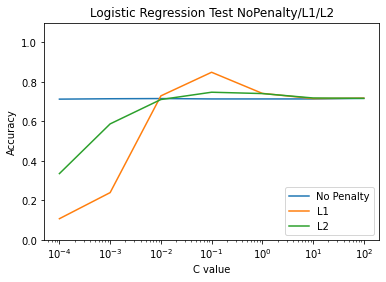

In [25]:

plt.title("Logistic Regression Test NoPenalty/L1/L2") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,LogReg_test_acc) 
plt.plot(cvals,LogRegL1_test_acc) 
plt.plot(cvals,LogRegL2_test_acc) 
plt.legend(['No Penalty', 'L1', 'L2'], loc='lower right')
plt.gca().set_ylim([0, 1.1])
plt.savefig('LogisticTestAccuracy.png')
plt.show()

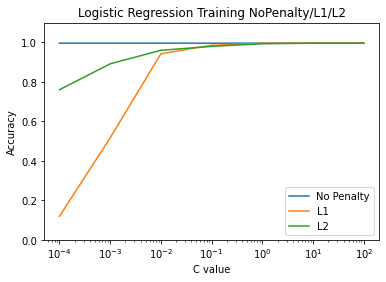

In [26]:

plt.title("Logistic Regression Training NoPenalty/L1/L2") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,LogReg_training_acc) 
plt.plot(cvals,LogRegL1_training_acc) 
plt.plot(cvals,LogRegL2_training_acc) 
plt.legend(['No Penalty', 'L1', 'L2'], loc='lower right')
plt.gca().set_ylim([0, 1.1])
plt.savefig('LogisticTrainingAccuracy.png')
plt.show()

## Accuracy of each penalty depending on cost

In [18]:
for idx, x in enumerate(LogReg_test_acc):
    print("current position: ",idx)
    print(LogReg_test_acc[idx])
    print(LogRegL1_test_acc[idx])
    print(LogRegL2_test_acc[idx])

current position:  0
0.7126213592233009
0.10776699029126213
0.33592233009708733
current position:  1
0.7145631067961166
0.23980582524271843
0.587378640776699
current position:  2
0.7155339805825243
0.729126213592233
0.7106796116504854
current position:  3
0.7135922330097088
0.8485436893203884
0.7475728155339805
current position:  4
0.7135922330097088
0.7417475728155339
0.7407766990291262
current position:  5
0.7135922330097088
0.7155339805825243
0.7184466019417476
current position:  6
0.716504854368932
0.7174757281553397
0.716504854368932


In [19]:
for idx, x in enumerate(LogReg_training_acc):
    print("current position: ",idx)
    print(LogReg_training_acc[idx])
    print(LogRegL1_training_acc[idx])
    print(LogRegL2_training_acc[idx])

current position:  0
0.9957213601275801
0.12000000000000002
0.7600319637015165
current position:  1
0.9955225435968658
0.5163020595570484
0.8912422530206194
current position:  2
0.9957877880440771
0.9420291382820567
0.9596501304733349
current position:  3
0.9957484701838786
0.9852990672510419
0.9795899035567472
current position:  4
0.9957216054221885
0.9950327847133634
0.9926628953736012
current position:  5
0.9957468777901249
0.9957336311766829
0.9955087904379237
current position:  6
0.9956549355714575
0.9956548470360804
0.9956283569233835
